# Analyse statistique de graphe avec package igraph 
*ZHANG Xiaopeng, LIU Ziyao*

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import random
ig.config["plotting.backend"] = "matplotlib"
ig.config["plotting.palette"] = "rainbow"

## Table des matières
1. [Introduction au package igraph](#part1)
2. [Fonctions personnalisées](#part2)
3. [Application dans l'analyse statistique de graphe](#part3)

## I. Introduction au package igraph <a id="part1"></a>

`igraph` est une bibliothèque Python performante pour l'analyse et la visualisation de graphes et de réseaux. Elle permet la création facile de graphes, leur manipulation, et l'analyse de leurs propriétés, ce qui la rend utile dans divers domaines comme la science des réseaux et la biologie computationnelle.

La structure $\verb?Graph()?$ dans igraph sert à créer des graphes. Elle peut être utilisée pour générer des graphes simples ou complexes, dirigés ou non dirigés, en fonction des besoins de l'utilisateur. Cette structure permet d'ajouter ou de supprimer des sommets (noeuds) et des arêtes (liens), offrant ainsi une grande liberté dans la construction et la modification des réseaux.

En plus de la construction de graphes, $\verb?Graph()?$ est essentielle pour accéder à une variété d'algorithmes d'analyse. Cela inclut des fonctionnalités pour explorer les chemins, analyser les structures de communauté, et évaluer la centralité et l'importance des noeuds. Ces outils analytiques aident à découvrir des informations cachées dans les structures de données complexes.

La visualisation est un autre atout de `igraph`, avec $\verb?Graph()?$ permettant de personnaliser la représentation graphique des données. Les utilisateurs peuvent ajuster les couleurs, formes et la disposition des éléments du graphe pour une meilleure clarté visuelle et une compréhension intuitive des données représentées.

Dans cette étude nous nous restreignons sur les graphes simple

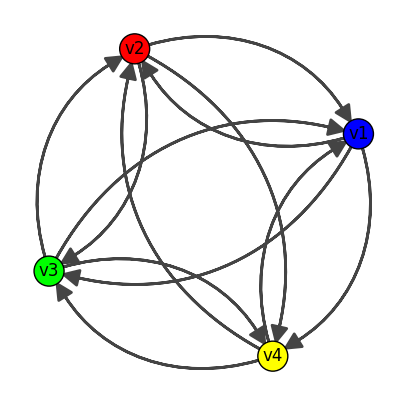

In [32]:
# Graph visualisation
g = ig.Graph.Full(n=4, directed=True)
fig, ax = plt.subplots(figsize = (5,5))
ig.plot(g, target=ax,
        vertex_color=['blue', 'red', 'green', 'yellow'],
        vertex_label=['v1', 'v2', 'v3', 'v4'])

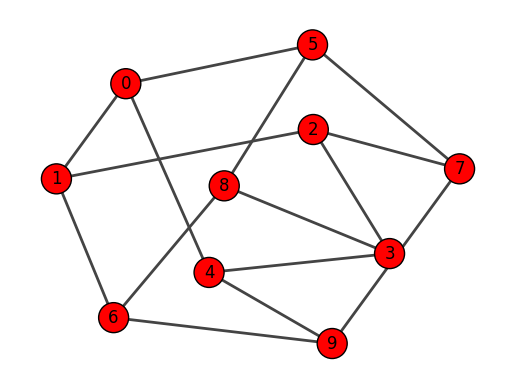

In [33]:
g = ig.Graph.Famous('Petersen')
g.vs["label"] = np.arange(10)
fig, ax = plt.subplots()
ig.plot(g, target=ax)

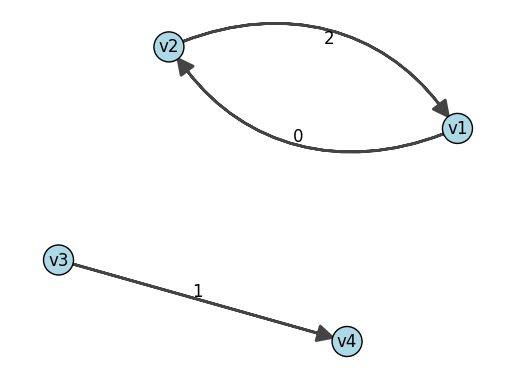

In [34]:
g = ig.Graph(n=4, 
             edges=[[0, 1], [2, 3], [1, 0]],
             directed=True)
g.es['weight'] = range(3)
fig, ax = plt.subplots()
ig.plot(g, target=ax, 
        layout = 'kamada_kawai', 
        vertex_color = 'lightblue', 
        edge_label = g.es['weight'], 
        vertex_label = ['v1', 'v2', 'v3', 'v4'])

In [35]:
m = g.get_adjacency()
m = list(m)
m = np.array(m)
m

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0]])

## II. Fonctions personnalisées<a id="part2"></a>

### Graph aléatoire
- Nous avons créé ici 3 algorithmes qui permettent de générer un graph aléatoire. Le 1er avec un modèle simple qui représente une approche intuitive mais difficile à simuler et le 2ème avec modèle Erdös-Rényi, et le 3ème avec modèle à bloc stochastique simplifié. 

$\verb?generer_rand_graph(n,M,directed = False)?$ se base du modèle suivant: 
Il s’agit de la collection $\mathcal{G}{(n,M)}$ de tous les graphes simples non dirigés d’ordre $n$ et de nombre d'arêtes $M$ muni de la loi uniforme $\mathbb{P}$ sur cette collection. Ainsi, la collection $\mathcal{G}{(n,M)}$ contient $\binom{N}{M}$ graph différent où $N=n(n-1)/2$

$\verb?generer_erdos_renyi(n,p)?$ génère donc un graph aléatoire selon le modèle Erdös-Rényi qui est à 2 paramètres: $n$ le nombre de noeuds du graph et $p\in]0,1[$ la probabilité de connextion de 2 noeuds pris au hasard. C'est un graph dont toutes les arêtes sont des variables aléatoires i.i.d de loi de Bernoulli $\mathcal{B}(p)$

$\verb?generer_SBM(n, blocks, block_matrix)?$ utilise le modèle à bloc stochastique qui est défini par les 3 paramètres suivants: N l'ordre du graph, $b$ le nombre de bloc et chaque noeud est associé à un bloc, et finalement $M$ la matrice de probabilté de bloc de taille $b\times b$ où l'élément $m_{kl}$ représente la probabilité qu'une arête soit créée entre un noeud du bloc $k$ et un noeud du bloc $l$

In [36]:
def generer_rand_graph(n, M, directed = False):
    '''
    Générer un graph aléatoirement 

    Args:
        n (int) : nombre de noeuds
        directed (bool) : orienté ou non 
    '''
    random_arrays = [np.random.randint(0, n-1, size=(1, 2)) for _ in range(M)]
    edges = [tuple(edge[0]) for edge in random_arrays]
    g1 = ig.Graph(n=n, edges=edges, directed=directed)
    g2 = g1.copy()
    g2.simplify()
    g2.vs['label'] = range(n)
    return g1, g2

In [37]:
def generer_erdos_renyi(n, p):
    """
    Générer un graph avec modèle Erdős-Rényi
    
    Args:
        n: Nombre de nœuds
        p: Probabilité de création d'une arête entre deux nœuds
    """
    g = ig.Graph()
    g.add_vertices(n)

    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                g.add_edges([(i, j)])

    return g

In [38]:
def generer_SBM(n, blocks, block_matrix):
    """
    Générer un graphe en utilisant le modèle à blocs stochastiques.

    Args
        n: Nombre de nœuds
        blocks: Liste avec le nombre de nœuds dans chaque bloc
        block_matrix: Matrice des probabilités de création d'arêtes entre les blocs
    """
    g = ig.Graph()
    g.add_vertices(n)

    # Attribuer chaque nœud à un bloc
    node_blocks = []
    for i, block_size in enumerate(blocks):
        node_blocks += [i] * block_size

    # Ajouter des arêtes en fonction de la matrice de bloc
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < block_matrix[node_blocks[i]][node_blocks[j]]:
                g.add_edges([(i, j)])

    return g

In [3]:
def affiche_communaute(g, ax, layout):
    '''
    Graphe visualisation illustrant la potentielle stucture de communauté au sein du graphe.
    
    Args:
        g (igraph.Graph) : graphe sur lequel on calcule la centralité d'intermédiarité en chaque noeud 
        ax (matplotlib.pyplot.axis) : target de la fonction ig.plot
        layout (str) : type de layout pour la visualisation du graphe. 
    '''
    communities = g.community_edge_betweenness()
    communities = communities.as_clustering()

    n = len(communities)
    palette = ig.RainbowPalette(n)
    for i, community in enumerate(communities):
        g.vs[community]["color"] = i
        #community_edges = g.es.select(_within=community)
        #community_edges["color"] = i

    ig.plot(communities, 
            target=ax, 
            palette = palette,
            vertex_size=20,
            layout = layout)

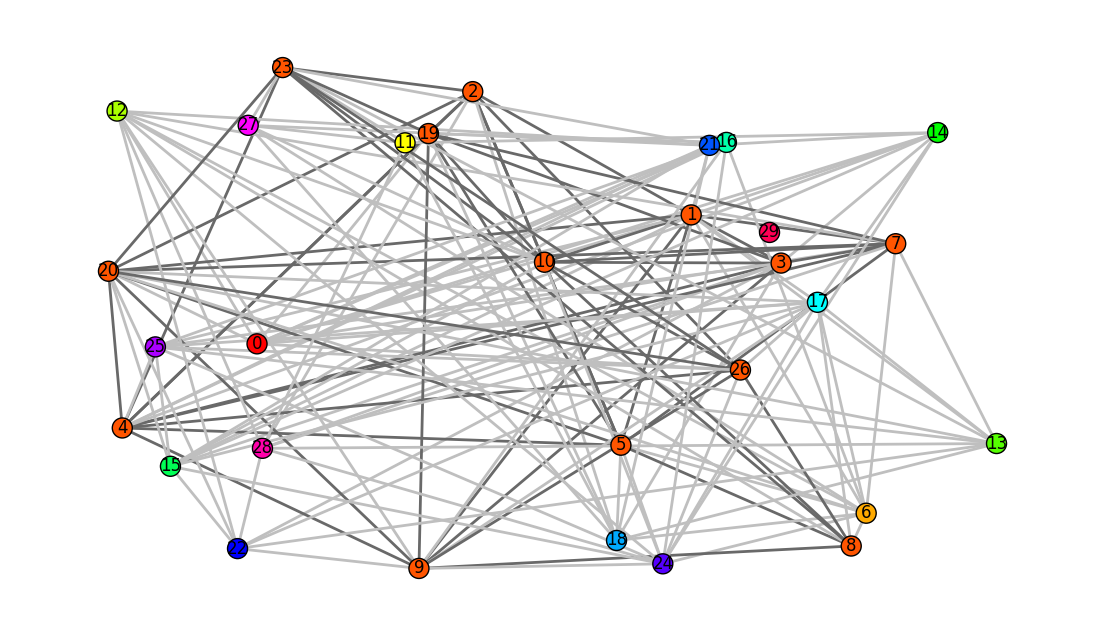

In [40]:
# Exemple d'utilisation 
g = generer_rand_graph(30, 200)[1]
fig, ax = plt.subplots(figsize=(14,8))
affiche_communaute(g, ax, 'random')

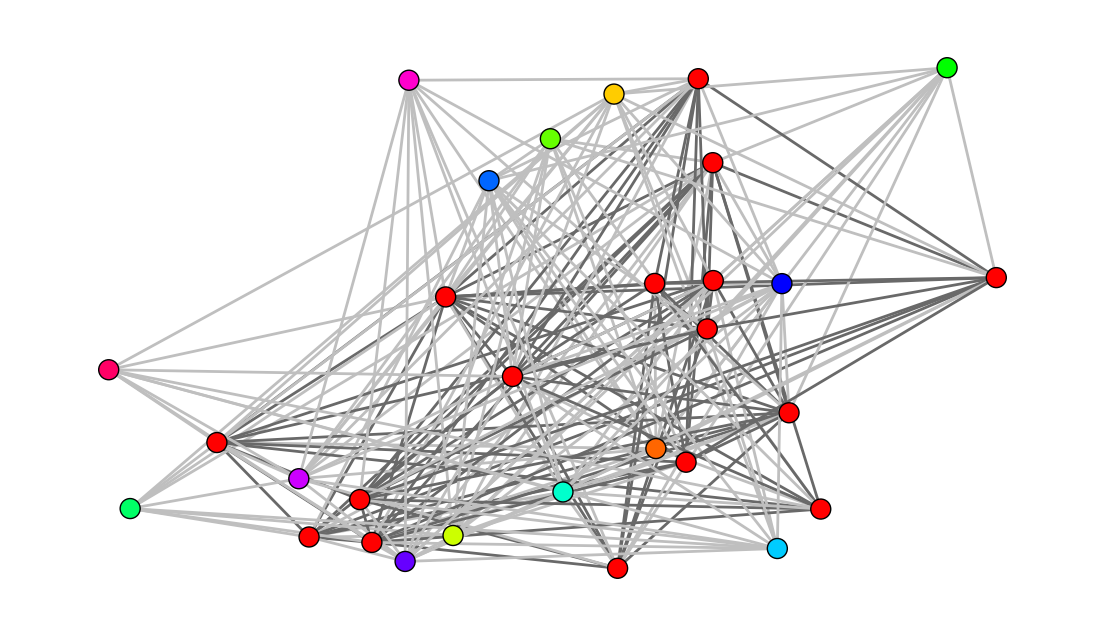

In [41]:
# Exemple d'utilisation 
g = generer_erdos_renyi(30, 0.5)
fig, ax = plt.subplots(figsize=(14,8))
affiche_communaute(g, ax, 'random')

- On peut observer ici que quand la probabilité de création d'arêtes au sein d'un bloc est assez haute, l'algorithme de détection de communauté peut alors identifier efficacement la structure de communauté du graph.

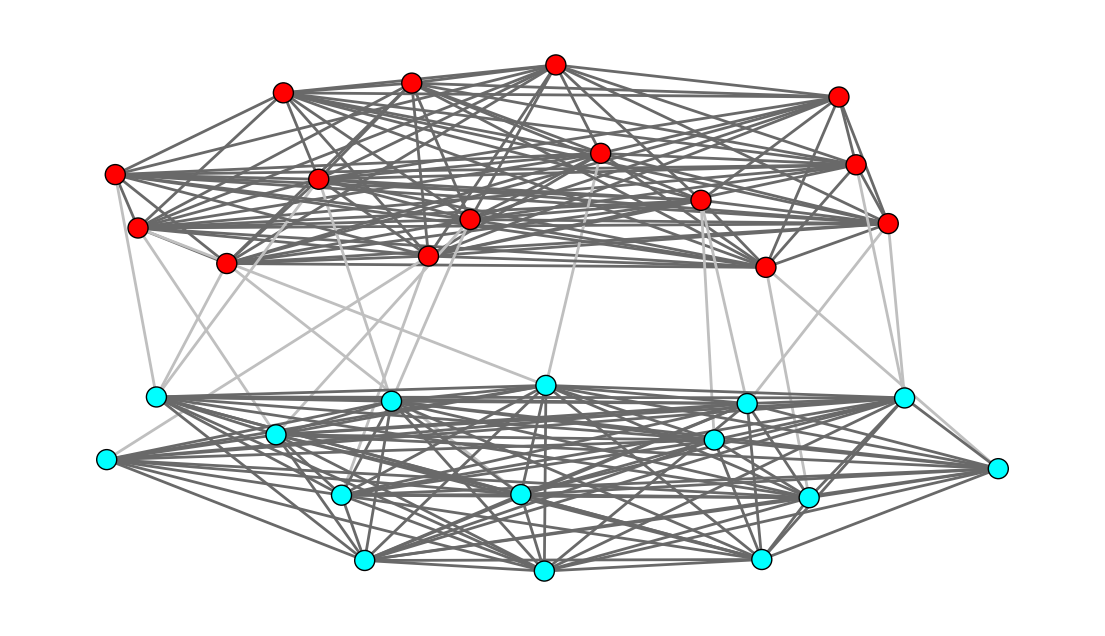

In [42]:
# Exemple d'utilisation
blocks = [15,15]
block_matrix = [[0.9,0.1],[0.1,0.9]]
g = generer_SBM(30, blocks, block_matrix)
fig, ax = plt.subplots(figsize=(14,8))
affiche_communaute(g, ax, 'kk')

**Centralité d'intermédiarité**
$$C_B(i)=\sum_{j,k:j\neq k\neq i} \frac{g_{jk}(i)}{g_{jk}}$$
$g_{jk}$ est le nombre de plus court chemin de $j$ à $k$ et $g_{jk}(i)$ le nombre de plus court chemin de $j$ à $k$ en passant par $i$ 

La centralité $C_B(i)$ d’un noeud est élevé, s’il est un point de passage sur un grand nombre de chemins les plus courts entre deux autres noeuds. Autrement dit, la plupart de la communication dans le graphe passe par lui.

In [43]:
def get_betweeness(g, ax, layout):
    '''
    Graphe visualization selon centralité d'intermédiarité des noeuds 
    avec colorbars indiquant la valeur pour chaque noeud
    
    Args:
        g (igraph.Graph) : graphe sur lequel on calcule la centralité d'intermédiarité en chaque noeud 
        ax (matplotlib.pyplot.axis) : target de la fonction ig.plot
        layout (str) : type de layout pour la visualisation du graphe. 
        ['circle', 'random', 'fruchterman_reingold', 'kamada_kawai', 'reingold_tilford', 'grid', 'lgl', ...]'
    '''
    n = g.vcount()
    noeud_betweenness = g.betweenness()
    noeud_betweenness_redimentionne = ig.rescale(noeud_betweenness, clamp = True)
    # Définir l'application betweeness -> couleur 
    cmap = LinearSegmentedColormap.from_list("sommet_cmap", ['aliceblue','navy'])
    g.vs['color'] = [cmap(betweenness) for betweenness in noeud_betweenness_redimentionne]
    ig.plot(g,target=ax[0],
            layout = layout,
            vertex_frame_width=0.1,
            vertex_size = 20,
            vertex_label = range(n))
    norme = ScalarMappable(norm=Normalize(0, max(noeud_betweenness)), cmap=cmap)
    plt.colorbar(norme, cax=ax[1], orientation="horizontal", label='Vertex Betweenness')

**Centralité de proximité**
$$C_P(i) = \left(\sum_{j\in V}\ell_{ij}\right)^{-1}$$
$l_{ij}$ est la distance entre noeud $i$ et $j$, et $V$ est l'ensemble des noeuds

La centralité $C_P(i)$ d’un noeud $i$ est élevé, quand sa distance à tous les autres noeuds est faible. Le noeud le plus central est “proche” de toute l’information dans le graphe.

In [44]:
def get_closeness(g, ax, layout):
    '''
    Graphe visualization selon centralité de proximité des noeuds 
    avec colorbars indiquant la valeur pour chaque noeud
    
    Args:
        g (igraph.Graph) : graphe sur lequel on calcule la centralité de proximité en chaque noeud 
        ax (matplotlib.pyplot.axis) : target de la fonction ig.plot
        layout (str) : type de layout pour la visualisation du graphe. 
        ['circle', 'random', 'fruchterman_reingold', 'kamada_kawai', 'reingold_tilford', 'grid', 'lgl', ...]'
    '''
    n = g.vcount()
    noeud_closeness = g.closeness()
    noeud_closeness_redimentionne = ig.rescale(noeud_closeness, clamp = True)
    # Définir l'application betweeness -> couleur 
    cmap = LinearSegmentedColormap.from_list("sommet_cmap", ['mistyrose','darkred'])
    g.vs['color'] = [cmap(closeness) for closeness in noeud_closeness_redimentionne]
    ig.plot(g,target=ax[0],
            layout = layout,
            vertex_frame_width=0.1,
            vertex_size = 20,
            vertex_label = range(n))
    norme = ScalarMappable(norm=Normalize(0, max(noeud_closeness)), cmap=cmap)
    plt.colorbar(norme, cax=ax[1], orientation="horizontal", label='Vertex Closeness')

In [45]:
def affiche_deg_histogram(g):
    '''
    Histogramme du degré des noeuds 
    
    Arg:
        g (igraph.Graph) : graphe selon lequel on obtient un histogramme de degré observé
    '''
    degree_counts = Counter(g.degree())
    labels, values = zip(*degree_counts.items())
    fig, ax = plt.subplots()
    bars = ax.bar(labels, values, label = labels)
    ax.grid(True, alpha = 0.5)
    ax.set_title("Histogram of degree distribution")
    ax.set_xlabel("degree")
    ax.set_ylabel("count")
    ax.set_xticks(labels, labels, rotation=90)
    ax.set_xscale
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

In [46]:
def affiche_centralite( g, layout_betweenness, layout_closeness, N=5):
    degrees = g.degree()
    if g.vs['label']:
        dict_degrees = {g.vs['label'][i]: degrees[i] for i in range(len(degrees))}
    else:
        dict_degrees = {i: degrees[i] for i in range(len(degrees))}
    topN_vertex = sorted(dict_degrees.items(), key=lambda item: item[1], reverse=True)[:N]
    topN_vertex = dict(topN_vertex)
    print("The {} vertex with highest degrees is shown below".format(N))
    for label, degree in zip(topN_vertex.keys(),topN_vertex.values()):
        print("%s: %d"%(label,degree))
    print("-"*125)
    affiche_deg_histogram(g)
    fig, ax = plt.subplots(2,2,figsize=(10,10), gridspec_kw={"height_ratios": (20, 1)})
    get_betweeness(g, ax=ax[:,0], layout=layout_betweenness)
    get_closeness(g, ax=ax[:,1], layout=layout_closeness)

The 5 vertex with highest degrees is shown below
2: 6
1: 5
3: 4
6: 4
7: 4
-----------------------------------------------------------------------------------------------------------------------------


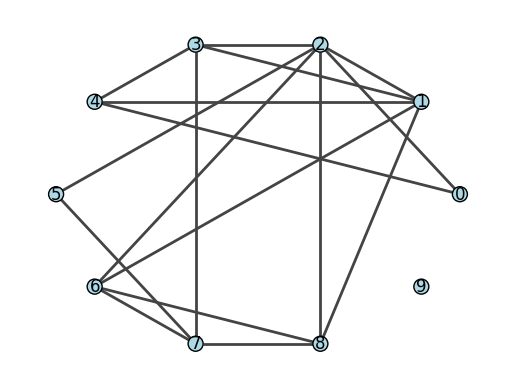

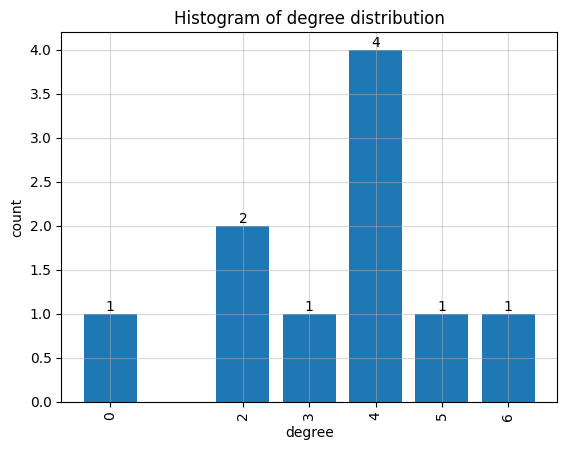

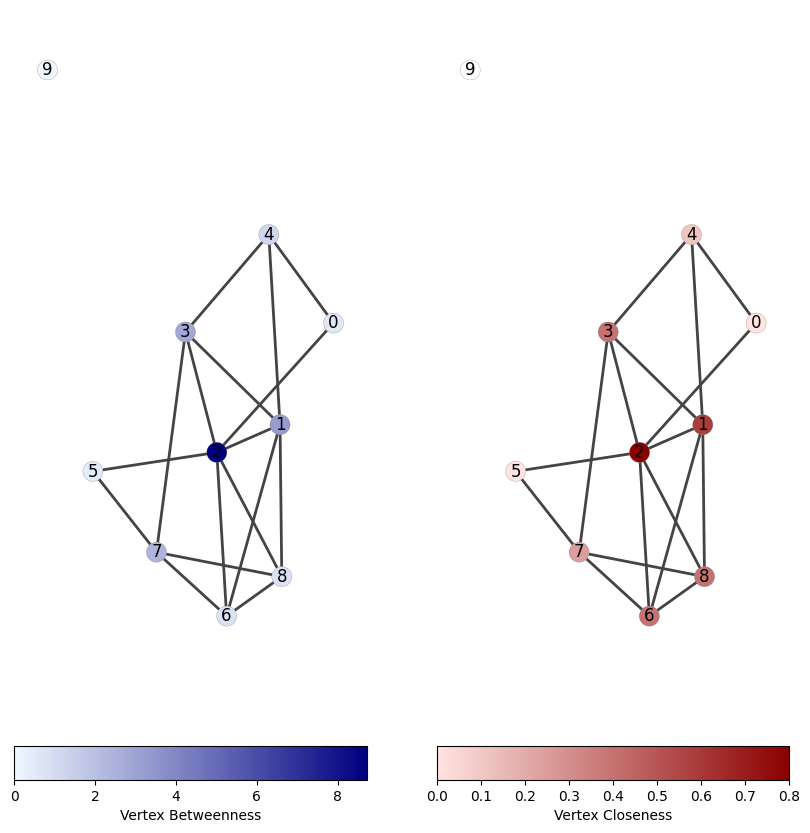

In [47]:
# Exemple d'utilisation
amis = generer_rand_graph(10,30)[1]
fig, ax = plt.subplots()
ig.plot(amis, target=ax, 
        layout = 'circle', 
        vertex_color = 'lightblue', 
        #edge_label = amis.es['weight'], 
        vertex_size=15,
        edge_size=5)
affiche_centralite(amis,'kk', 'kk')

**point de coupure**

Un point de coupure ou cutpoint est un sommet qui, si on le supprime du graphe, augmente le nombre de composantes connexes.
Retirer un point de coupure d’un graphe implique que certains noeuds ne peuvent plus communiquer entre eux.

In [48]:
def trouver_points_coupure(g):
    """
    Trouve les points de coupure dans le graphe donné en utilisant l'algorithme de Tarjan.
    
    Args:
    g (igraph.Graph): Le graphe dans lequel trouver les points de coupure.
    
    Returns:
    Graph.Vertex : Une liste des nœuds qui sont les points de coupure dans le graphe.
    """
    def dfs(noeud, visite, decouverte, bas, parent, ap, temps):
        enfants = 0
        visite[noeud] = True
        decouverte[noeud] = temps[0]
        bas[noeud] = temps[0]
        temps[0] += 1

        for voisin in g.neighbors(noeud):
            if not visite[voisin]:
                parent[voisin] = noeud
                enfants += 1
                dfs(voisin, visite, decouverte, bas, parent, ap, temps)

                bas[noeud] = min(bas[noeud], bas[voisin])

                if parent[noeud] == -1 and enfants > 1 or parent[noeud] != -1 and bas[voisin] >= decouverte[noeud]:
                    ap[noeud] = True
            elif parent[noeud] != voisin:
                bas[noeud] = min(bas[noeud], decouverte[voisin])

    visite = [False] * g.vcount()
    decouverte = [float('inf')] * g.vcount()
    bas = [float('inf')] * g.vcount()
    parent = [-1] * g.vcount()
    ap = [False] * g.vcount()
    temps = [0]

    for i in range(g.vcount()):
        if not visite[i]:
            dfs(i, visite, decouverte, bas, parent, ap, temps)

    idx = [i for i in range(g.vcount()) if ap[i]]
    return [g.vs(idx), idx]

In [49]:
def affiche_point_coupure(g):
    n = g.vcount()
    points_coupure = trouver_points_coupure(g)[0]
    fig, ax = plt.subplots()
    ig.plot(g, target=ax, vertex_label = range(n), 
        vertex_color = ['red' if i in points_coupure else 'lightblue' for i in g.vs] )

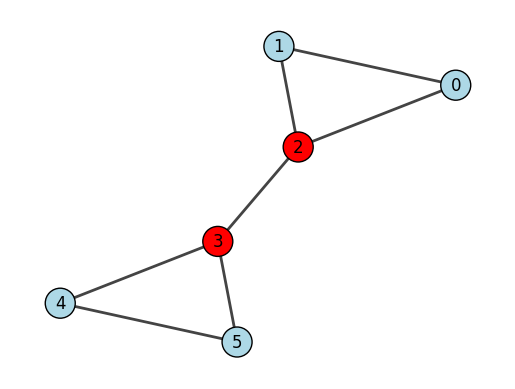

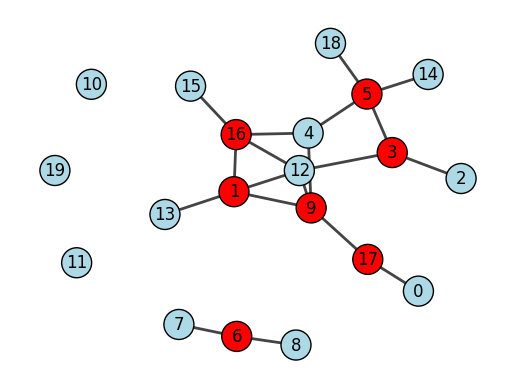

In [50]:
# Exemple d'utilisation
aretes = [(0, 1), (0, 2), (1, 2), (2, 3), (3, 4), (4, 5), (5, 3)]
g = ig.Graph(edges=aretes, directed=False)
affiche_point_coupure(g)
g = generer_rand_graph(20,20)[1]
affiche_point_coupure(g)

## III. Application dans l'analyse statistique de graphe<a id="part3"></a>

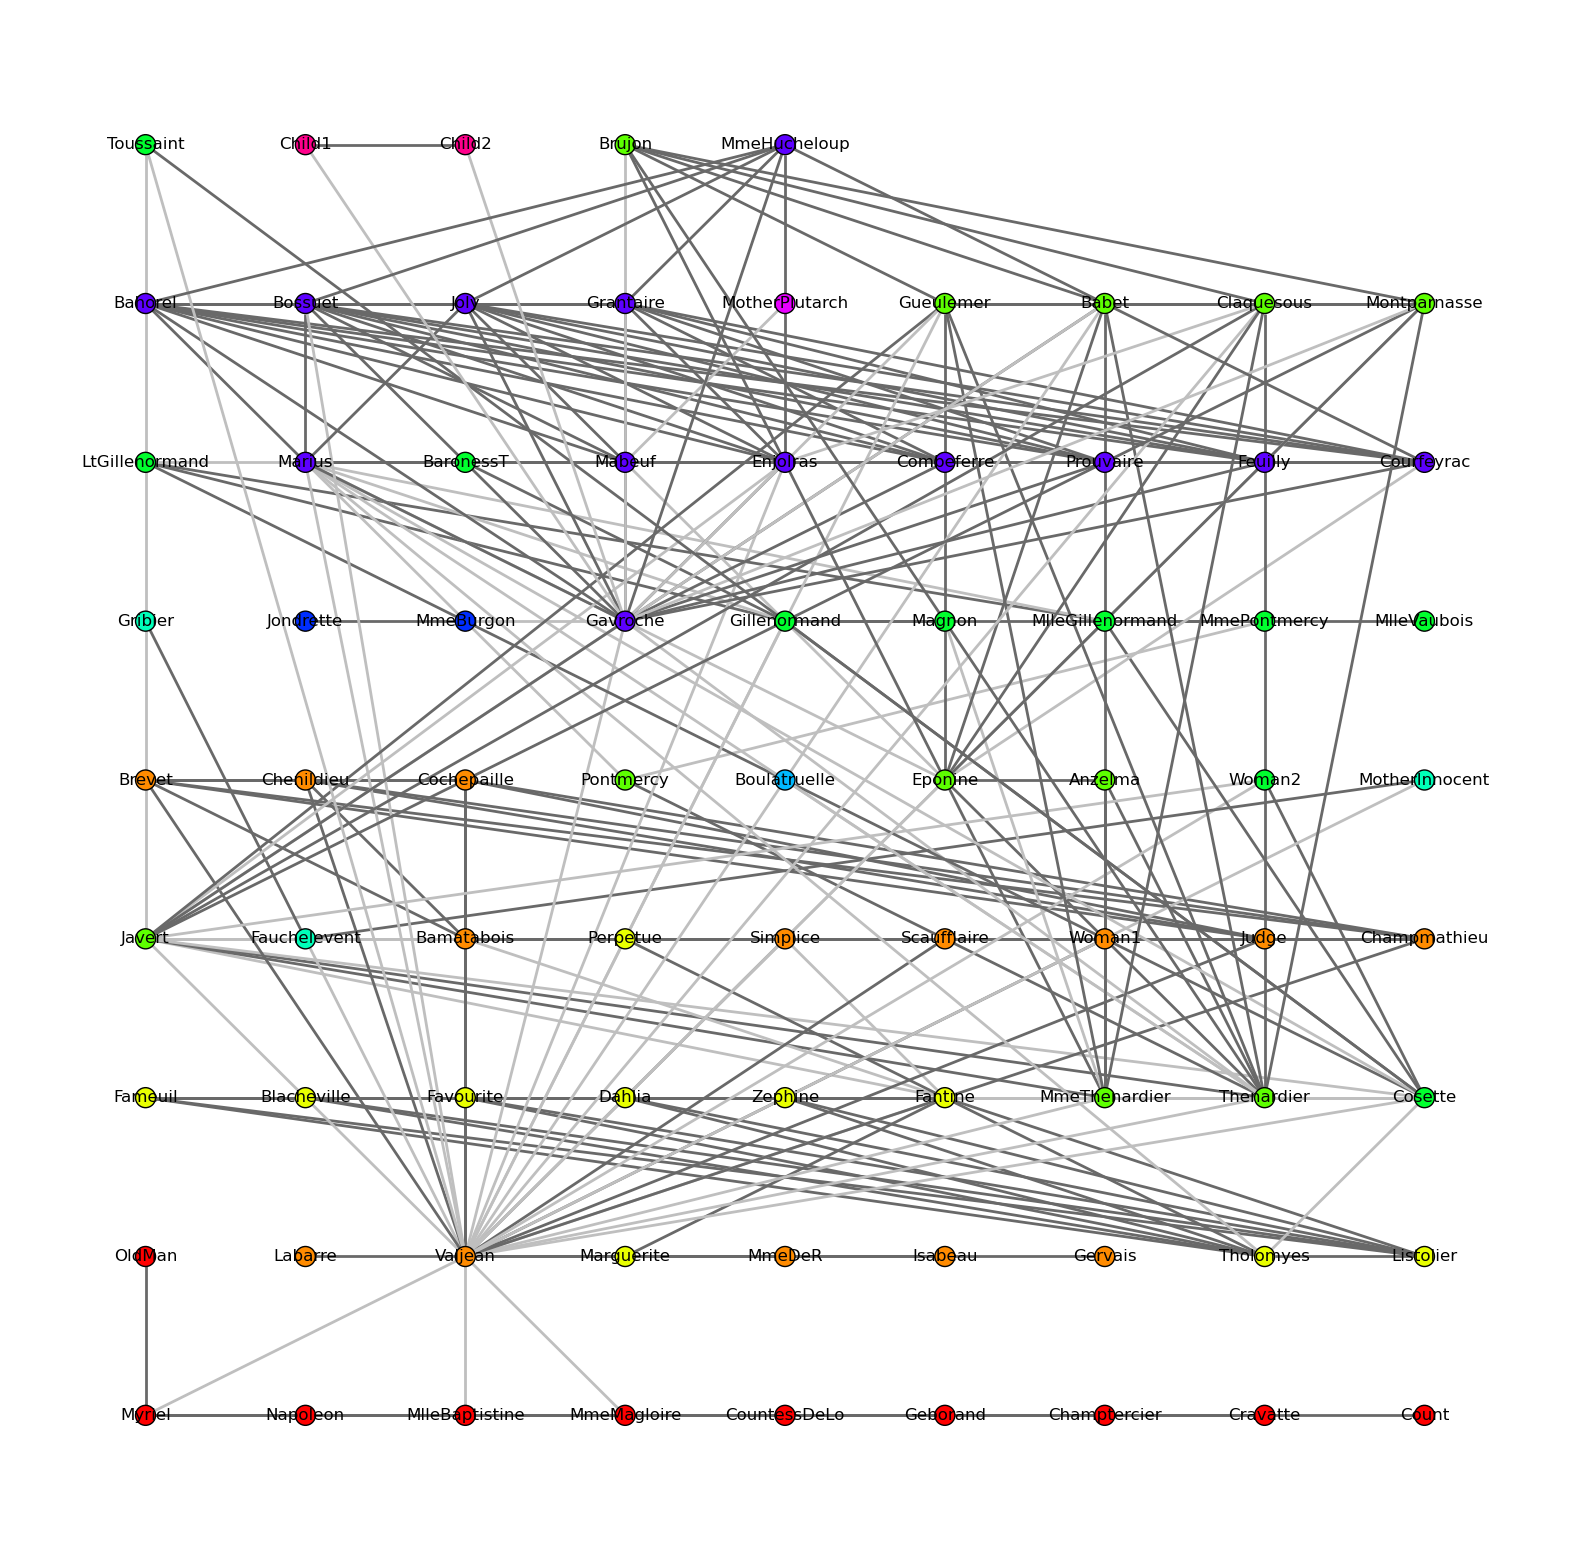

In [4]:
g = ig.Graph.Load('dataset/lesmis.gml', format='gml')
fig, ax = plt.subplots(figsize=(20,20))
affiche_communaute(g, ax, 'grid')

The 10 vertex with highest degrees is shown below
Valjean: 36
Gavroche: 22
Marius: 19
Javert: 17
Thenardier: 16
Fantine: 15
Enjolras: 15
Courfeyrac: 13
Bossuet: 13
Bahorel: 12
-----------------------------------------------------------------------------------------------------------------------------


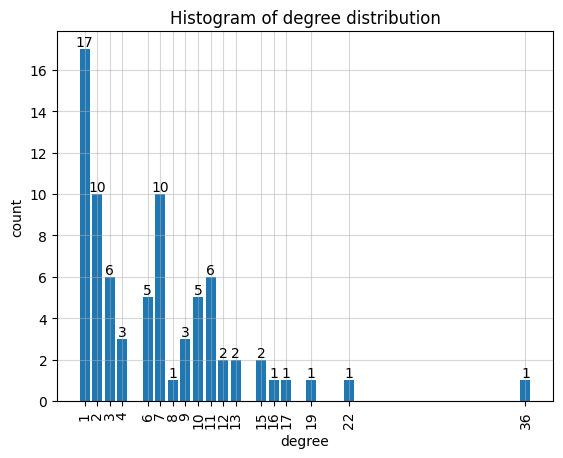

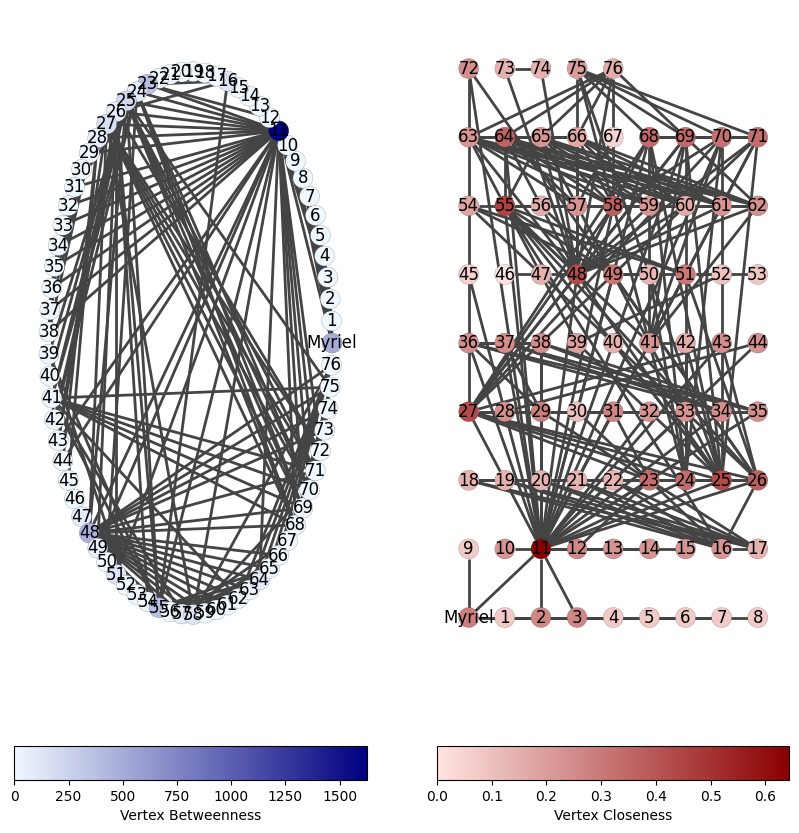

In [52]:
affiche_centralite(g, 'circle', 'grid', N=10)

Visuellement, en combinant les 2 résultats de mesure de centralité on remarque que les sommets d'index suivant sont au centre du roman 

In [53]:
idx = [0, 11, 23, 25, 48]
g.vs(idx)['label']

['Myriel', 'Valjean', 'Fantine', 'Thenardier', 'Gavroche']

['Myriel', 'Valjean', 'Thenardier', 'Fauchelevent', 'MmeBurgon', 'Gavroche', 'MlleGillenormand', 'Mabeuf']
leurs index sont  [0, 11, 25, 28, 47, 48, 51, 57]


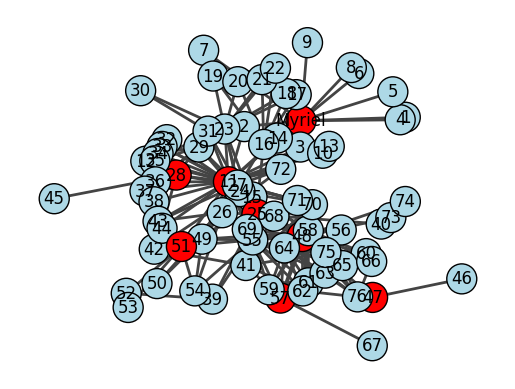

In [54]:
print(trouver_points_coupure(g)[0]['label'])
print("leurs index sont ",trouver_points_coupure(g)[1])
affiche_point_coupure(g)

In [55]:
personnages_degre = set(['Valjean', 'Gavroche', 'Marius', 'Javert', 'Thenardier' ])
personnages_centre = set(['Myriel', 'Valjean', 'Fantine', 'Thenardier', 'Gavroche'])
point_coupure = set(['Myriel', 'Valjean', 'Thenardier', 'Fauchelevent', 'MmeBurgon', 'Gavroche', 'MlleGillenormand', 'Mabeuf'])
print("Résultat combiant degré et point de coupure:", personnages_degre&point_coupure)
print("Résultat combiant degré et point de coupure:", personnages_centre&point_coupure)

Résultat combiant degré et point de coupure: {'Valjean', 'Thenardier', 'Gavroche'}
Résultat combiant degré et point de coupure: {'Valjean', 'Gavroche', 'Thenardier', 'Myriel'}


En analysant les sommets de plus haut degré dans notre réseau de personnages, nous avons identifié 'Valjean', 'Gavroche', 'Marius', 'Javert' et 'Thenardier' comme étant les figures centrales. Cette approche initiale met en lumière les personnages ayant le plus grand nombre de connexions dans l'œuvre, suggérant leur importance prédominante.

Cependant, en affinant notre analyse à travers deux mesures de centralité plus sophistiquées, à savoir la centralité de proximité (closeness) et la centralité d'intermédiarité (betweenness), nous avons obtenu un ensemble légèrement différent de personnages clés : 'Myriel', 'Valjean', 'Fantine', 'Thenardier' et 'Gavroche'. Cette observation enrichit notre compréhension en mettant en avant non seulement les personnages les plus connectés, mais aussi ceux qui jouent un rôle crucial dans le maintien de la cohésion du réseau narratif.

En combinant ces résultats avec la liste des points de coupure - des personnages essentiels pour maintenir la structure du réseau - nous obtenons un aperçu plus concentré et précis de l'importance des personnages. Bien que cette méthode réduise le spectre des personnages analysés, elle révèle ceux qui sont véritablement indispensables à la trame du roman.

Il est important de noter que se concentrer uniquement sur ces personnages peut limiter la compréhension globale de l'œuvre. Néanmoins, cette approche offre un guide de lecture précieux, en particulier pour les lecteurs qui ne sont pas familiers avec l'univers de Victor Hugo. En gardant à l'esprit ces figures centrales, la découverte et l'appréciation de ce roman complexe et riche en personnages devient plus accessible.